<a href="https://colab.research.google.com/github/shidsaa/sharepoint-mcp/blob/main/custom%20mmocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMOCR Tutorial

Welcome to MMOCR! This is the **unofficial** colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Transform annotation in coco-like json format to MMOCR compatible format.
- Set custom configuration file
- Integrate mmocr config template extracted from `base` with user custom setting
- Train a text recognizer with a toy dataset.
- Resume training from exisiting `training model`.
- Load a pretrained model

Authors: Rodney Petrus Balandong balandongiv@gmail.com

Part of noteebook content were extracted from the MMOCR official documentation

# Install MMOCR

When installing dependencies for mmocr, please ensure that all the dependency versions are compatible with each other. For instance, if CUDA 10.1 is installed, then the Pytorch version must be compatible with cu10.1. Please see [getting_started.md](docs/getting_started.md) for more details.

In [1]:
%cd ..

/


### Check PyTorch version

In [2]:
!pip show torch

Name: torch
Version: 2.8.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


### Install Dependencies

In [ ]:
# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

# Install mmdetection
!pip install mmdet

# # Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

!pip install gdown

Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 27.3 MB/s eta 0:00:00


### Check Installed Dependencies Versions

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /mmocr/
!ls

1.11.0+cu113 True
2.25.0
1.5.3
11.3
GCC 7.3
0.6.0
/mmocr
CITATION.cff  docs	   mmocr.egg-info   requirements      setup.py
configs       LICENSE	   model-index.yml  requirements.txt  tests
demo	      MANIFEST.in  README.md	    resources	      tools
docker	      mmocr	   README_zh-CN.md  setup.cfg


#Perform Training on a Toy Dataset with MMOCR Recognizer
We now demonstrate how to perform training with an MMOCR recognizer. Since training a full academic dataset is time consuming (usually takes about several hours), we will train on the toy dataset for the SAR text recognition model and visualize the predictions.

Training a dataset usually consists of the following steps:
1. Convert the dataset into a format supported by MMOCR (e.g. COCO for text detection). The annotation file can be in either .txt or .lmdb format, depending on the size of the dataset. This step is usually applicable to customized datasets, since the datasets and annotation files we provide are already in supported formats.
2. Modify the config for training.
3. Train the model.



## About the Toy Dataset

In this tutorial, we will be working with the dataset under the folder `toy_dataset`.

Each of the image have the accompnying `annotation` file generated using the `labelme`

The images were stored under the following path

`/mmocr/tests/data/toy_dataset/imgs/test`

The annotation were stored under  the following path

`/mmocr/tests/data/toy_dataset/labelme`




In [ ]:
# Print list of images and annotation available under the`toy_dataset` folder
!cat /mmocr/tests/data/toy_dataset/img_list.txt

img_10.jpg
img_1.jpg
img_2.jpg
img_3.jpg
img_4.jpg
img_5.jpg
img_6.jpg
img_7.jpg
img_8.jpg
img_9.jpg


We first get a sense of what the toy dataset looks like by visualizing one of the images and labels.

/


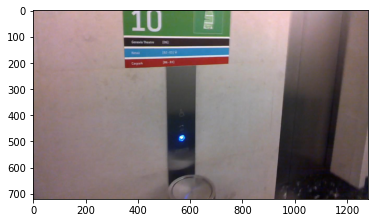

In [ ]:
import mmcv
import matplotlib.pyplot as plt

#To ensure we are in the root directory
%cd ..

img = mmcv.imread('/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg')

plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Let visualise the annotation

In [ ]:
!cat /mmocr/tests/data/toy_dataset/labelme/img_1.json

{
  "version": "5.0.1",
  "flags": {},
  "shapes": [
    {
      "label": "Genaxis Theatre",
      "points": [
        [
          377,
          117
        ],
        [
          463,
          117
        ],
        [
          465,
          130
        ],
        [
          378,
          130
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "[06]",
      "points": [
        [
          493,
          115
        ],
        [
          519,
          115
        ],
        [
          519,
          131
        ],
        [
          493,
          131
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "###",
      "points": [
        [
          374,
          155
        ],
        [
          409,
          155
        ],
        [
          409,
          170
        ],
        [
          374,
          170
        ]
      ],
      "group

## Prepare Annotation to MMOCR format

Since the annotations are in COCO format, we need to firstly convert annotation in labelme format to MMOCR's annotation format using the `labelme_converter.py`.

For this particular example, we will convert the labelme format annotation in `/mmocr/tests/data/toy_dataset/labelme` to MMOCR detection labels instances_training `.txt` and export the cropped image patches for recognition task to `/mmocr/tests/data/toy_dataset/crops`. It is worth to note that the following setting would not output the `test_label.txt` as there is no test set. This information is important  when assigning  `test_anno_file1` to `train_label.txt` in subsequent step.

In Google colab, it is essential to add a `!` before the Python command.


For this particular dataset, preferable to use the `.jsonl` as the annotation output

In [ ]:
!python /mmocr/tools/data/common/labelme_converter.py /mmocr/tests/data/toy_dataset/labelme /mmocr/tests/data/toy_dataset/imgs/test /mmocr/tests/data/toy_dataset --tasks recog --format jsonl

[>>] 10/10, 91.5 task/s, elapsed: 0s, ETA:     0s
finish


Let have a look what files has been generated from the previous calling

In [ ]:
# List of crop images that being crop in accordance to the bounding box
import os
root = '/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored
path_crop_img=os.path.join(root,'crops')
print([os.path.join(path, name) for path, subdirs, files in os.walk(path_crop_img) for name in files])

['/mmocr/tests/data/toy_dataset/crops/img_3/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_3/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_2/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_2/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_9/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_9/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_3.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/c

Lets visualise the MMOCR detection labels instances_training `.jsonl`

In [ ]:
!cat /mmocr/tests/data/toy_dataset/train_label.jsonl

{"filename": "/mmocr/tests/data/toy_dataset/crops/img_7/crop_0.jpg", "text": "citi"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_7/crop_1.jpg", "text": "smrt"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_3/crop_0.jpg", "text": "fusionopolis"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_3/crop_1.jpg", "text": "fusionopolis"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg", "text": "Reserve"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg", "text": "CAUTION"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_9/crop_0.jpg", "text": "EXIT"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_9/crop_1.jpg", "text": "STAGE"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_8/crop_0.jpg", "text": "WHY"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_8/crop_1.jpg", "text": "PAY"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_8/crop_2.jpg", "text": "FOR"}
{"filename": "/mmocr/tests/data/toy_dataset/c

In [ ]:
!wget https://github.com/balandongiv/mmocr_tutorial/blob/main/my_cfg.py.txt

--2022-06-27 04:06:29--  https://github.com/balandongiv/mmocr_tutorial/blob/main/my_cfg.py.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-27 04:06:30 ERROR 404: Not Found.



## Configuration file

The MMOCR's config system incorporate modular and inheritance design, which is convenient to conduct various experiments.

**REMARK**
The modular code in each cell is for explaination purpose, toward the end, the code will be paste in a `.py` file.


The config file structure consist on the parameter
1. [model](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#model),
2. [data & pipeline](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#data-pipeline),
3. [training schedule](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#training-schedule), and
4. [runtime setting](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#runtime-setting).

Please refer to [config file structure](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#config-file-structure) for detailed documentation

Firstly, We import the four predefine configurations of the `model`, `data $ pipeline`, `training schedule` and `runtime setting` as follow.



```
_base_ = [
    '/mmocr/configs/_base_/recog_models/sar.py',
    '/mmocr/configs/_base_/recog_pipelines/sar_pipeline.py',
    '/mmocr/configs/_base_/schedules/schedule_adam_step_5e.py',
    '/mmocr/configs/_base_/default_runtime.py',
]
```

Notice that all files were configured under the `.py` extension. It is important to note that the `.py` cannot contain `modular` such as `import os`.


The pipeline can be assigned as



```
train_pipeline = {{_base_.train_pipeline}}
test_pipeline = {{_base_.test_pipeline}}
```



Define the training and validation datasets.

In this tutorial, we are using the `crop` images ( `mmocr/tests/data/toy_dataset/crops`) and its annotation (`mmocr/tests/data/toy_dataset/train_label.jsonl`) as a training dataset.

The training dataset can be configured as;

```
dataset_type = 'OCRDataset'
root = '/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored

img_prefix ='/mmocr/tests/data/toy_dataset/crops'
train_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.jsonl'


loader_dt_train = dict(type='AnnFileLoader',
                            repeat=100,                   
                            file_format='txt',  # only txt and lmdb
                            file_storage_backend='disk',
                            parser=dict(type='LineJsonParser',
                                        keys=['filename', 'text']))

train_datasets1 = dict(type='OCRDataset',
                       img_prefix=img_prefix,
                       ann_file=train_anno_file1,
                       loader=loader_dt_train,
                       pipeline=None,           
                       test_mode=False)


train_list = [train_datasets1]


We also need to configure the `testing` dataset. For simplicity, we assume the training and test dataset are the same

```
loader_dt_val = dict(type='AnnFileLoader',
                            repeat=1,                   
                            file_format='txt',  # only txt and lmdb
                            file_storage_backend='disk',
                            parser=dict(type='LineJsonParser',
                                        keys=['filename', 'text']))

train_datasets1 = dict(type='OCRDataset',
                       img_prefix=img_prefix,
                       ann_file=train_anno_file1,
                       loader=loader_dt_val,
                       pipeline=None,           
                       test_mode=False)


test_list =  [train_datasets1]
```

More detail about [repeat](https://github.com/open-mmlab/mmocr/issues/858#issuecomment-1166156290)

The pipeline for `train` and `test` can be configured as below



```
train_pipeline = {{_base_.train_pipeline}}
test_pipeline = {{_base_.test_pipeline}}
```



We also need to specify to direectory to save all files and logs.

`work_dir = '/mmocr/demo/tutorial_exps'`

Finally, assign all the informations into the `data` dictionary. It is worth to note, this setting is almost similar to the build-in [script](https://github.com/open-mmlab/mmocr/blob/72a79f9350277566caae2fdf3ab9cd614f313d28/configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py#L14).



```
data = dict(
    workers_per_gpu=2,
    samples_per_gpu=8,
    train=dict(
        type='UniformConcatDataset',
        datasets=train_list,
        pipeline=train_pipeline),
    val=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline),
    test=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline)
    )

evaluation = dict(interval=1, metric='acc')
```

As mentioned, this `cfg` need to be stored in a `.py` file.
For simplicity, lets download the `.py` file and stored at `/content/my_cfg.py`.

In [ ]:
import gdown
gdown.download(url='https://drive.google.com/file/d/1mv3JSGfPhzlSzCRPN9Ddsd_9mQILLhVV/view?usp=sharing', output='/content/', quiet=True, fuzzy=True)

'/content/my_cfg.py'

Lets create the configration file

In [ ]:
from mmcv import Config

cfg = Config.fromfile('/content/my_cfg.py')

It is also possible to modify the `cfg` post creation.

In order to perform inference for carnn on colab, we need to adjust the config values to accommodate some of the settings of colab such as the number of GPU available.

In [ ]:
from mmdet.apis import set_random_seed


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# For detail discussion See https://github.com/open-mmlab/mmocr/issues/681#issuecomment-1009526228
cfg.optimizer = dict(type = 'Adam',
                 lr = 0.001 / 8)


cfg.lr_config = dict(policy = 'step',
                 step = [3, 4],
                 warmup = None  # Set warmup to None when work in Colab
                 )


cfg.log_config = dict(
                  interval = 5,  # Choose to log training results every 40 images to reduce the size of log file.
                  hooks = [dict(type = 'TextLoggerHook')])

seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let also limit the training to only 6 epochs

cfg.runner = dict(type='EpochBasedRunner', max_epochs=6)

#save the model every 2 epoch
cfg.checkpoint_config = dict(interval=2)
# print(f'Config:\n{cfg.pretty_text}')

Let also change the [dict_type](https://github.com/open-mmlab/mmocr/issues/1113) to recognize characters from `0~9` , `A~Z` and `a-z` only and `no space`,

In [ ]:
# Please Ignore this, This is for troubleshooting purpose only
# DICT62=['0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'] # 62 characters

# """
# 'BaseConvertor', 'CTCConvertor', 'AttnConvertor', 'SegConvertor','ABIConvertor'
# """

# # Original value
# # label_convertor = dict(type='AttnConvertor', dict_type='DICT90', with_unknown=True)

# cfg.label_convertor = dict(
#     type='AttnConvertor', dict_type=None,dict_list=DICT62, with_unknown=False,lower=False)

# cfg.model.label_convertor=cfg.label_convertor





## Train the SAR Text Recognizer
Finally, we train the SAR text recognizer on the toy dataset for five epochs.

This steps took about ~ 5 minutes to complete or <15 if Colab is connected with GPU


In [ ]:
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# # Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# # Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# # Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/mmocr/mmocr/apis/utils.py:53: UserWarning: Remove "MultiRotateAugOCR" to support batch inference since samples_per_gpu > 1.
  warnings.warn(warning_msg)
2022-06-27 04:07:51,299 - mmocr - INFO - Start running, host: root@0911d87d2aae, work_dir: /mmocr/demo/tutorial_exps
2022-06-27 04:07:51,305 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook      

Exception: ignored

## Test and Visualize the Predictions

For completeness, we also perform testing on the latest checkpoint and evaluate the results with hmean-iou metrics. The predictions are saved in the ./outputs file.

In [ ]:
# Visualize the testing image.
img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg' # This should be an overfit, since we testing an image that has been used for training!

_img = mmcv.imread(img)
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(_img))
plt.show()

In [ ]:
print(cfg.work_dir)

In [ ]:
from mmocr.apis import init_detector, model_inference


img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg'  # This should be an overfit, since we testing an image that has been used for training!



checkpoint=os.path.join(cfg.work_dir,'epoch_5.pth')


out_file = 'outputs/1036169s.jpg'   # Rendered image save location

model = init_detector(cfg, checkpoint, device="cuda:0")
if model.cfg.data.test['type'] == 'ConcatDataset':
    model.cfg.data.test.pipeline = model.cfg.data.test['datasets'][0].pipeline

# Lets do inference to the image using the model that we just train.
result = model_inference(model, img)
print(f'result: {result}')

img = model.show_result(img, result,
                        out_file=out_file,
                        show=False)

mmcv.imwrite(img, out_file)

In [ ]:
# Visualize the results
predicted_img = mmcv.imread('./outputs/1036169s.jpg')
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

# Resume Training from existing training point


In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed
cfg = Config.fromfile('/content/my_cfg.py')


cfg.gpu_ids = range(1)

# Let also limit the training to only 12 epochs

cfg.runner = dict(type='EpochBasedRunner', max_epochs=20)

#save the model every 2 epoch
cfg.checkpoint_config = dict(interval=5) # Default the interval was set to 100

print(f'Config:\n{cfg.pretty_text}')

mmocr offer the capability to `resume` training.



or use `pre-trained` model which will be used to initialize the network paramters.

Please select or set either `resume_from` or `load_from`

To ` resume` training

In [ ]:
# Resume training from a previously saved checkpoint, which will inherit the training epoch and optimizer parameters.
cfg.resume_from='/mmocr/demo/tutorial_exps/epoch_6.pth'

To use a `pre-trained` model

In [ ]:
# Path to the pre-trained model
cfg.load_from='/mmocr/demo/tutorial_exps/epoch_6.pth'

# Interesting discussion from MMOCR github



1.   Turn on imshow for [debugging](https://github.com/open-mmlab/mmocr/issues/410#issuecomment-892480963)
2.   Different methods support differnet number of classes [(tokens)](https://github.com/open-mmlab/mmocr/issues/424#issuecomment-896568710). For example, SAR is DICT90 while CRNN is DICT36. But for evaluation metric, they are the same.
3. `word_acc_ignore_case_symbol` is the [results that removing some tokens](https://github.com/open-mmlab/mmocr/issues/424#issuecomment-896574323) that are not a number or English characters.
4. Evaluating on DICT36 is common sense in the academic community because it can get a [higher accuracy](https://github.com/open-mmlab/mmocr/issues/424#issuecomment-1086852698).
5. Problems in training MJ + ST training set using robustscanner algorithm ( [Issue](https://github.com/open-mmlab/mmocr/issues/508))
6. [visualize loss curve](https://github.com/open-mmlab/mmocr/issues/514).
7. [Finetuning a model generally](https://github.com/open-mmlab/mmocr/issues/565#issuecomment-963916718) requires a much smaller learning rate than training from scratch. And it's hard to finetune the model for special cases, especially when your data is not large enough and your model is just likely to overfit.
8. To extract only metric results, [batch testing would be enough](https://github.com/open-mmlab/mmocr/issues/594#issuecomment-971176307).
9. char_precision is the average percentage of predicted characters that correctly match the ground truth texts. 1-N.E.D is an official metric used in the ICDAR competition where N.E.D stands for Normalized Edit Distance. The motivation of adaptation is that "Chinese script has much more and also usually longer vocabulary than Latin script, which makes word accuracy metric too harsh to proper evaluate T2.2". (read https://rrc.cvc.uab.es/?ch=14&com=tasks). And it's better to read through their implementation [REF](https://github.com/open-mmlab/mmocr/issues/760#issuecomment-1034664840)

10. How to handle space. [Trick 1](https://github.com/open-mmlab/mmocr/issues/766#issuecomment-1030861493), or How [Create OCR for only number?](https://github.com/open-mmlab/mmocr/issues/766)

`label_convertor = dict(
    type='CTCConvertor', dict_list=list('0123456789 '), with_unknown=False)`


11. label.txt and label.lmdb contain exactly the same data in two different formats. This toy dataset demo is designed to demonstrate the usage of different data formats, and how to concat multiple datasets. For real applications, you only need to prepare the data annotations in one format (.txt or .lmdb).[ref](https://github.com/open-mmlab/mmocr/issues/817#issuecomment-1061543477)

11. Diffrence difference between the 'load_from' and 'resume_from' . A checkpoint file contains not only the weights of the model but metadata of the training state, e.g., the current iteration # and the learning rate. --load-from only loads the weights from the checkpoint and starts training from the very first iteration, whereas --resume-from loads additional metadata to resume exactly from the stage where the checkpoint was saved [ref](https://github.com/open-mmlab/mmocr/issues/839#issuecomment-1067462651).
12. Use case to repeat the training on a train dataset for x repeat of times?>> Sometimes this feature is needed when we train a model on a set of datasets with imbalanced sizes, where tiling the small dataset several times is the most straightforward way to alleviate the bias brought by the large ones. [SAR](https://mmocr.readthedocs.io/en/latest/textrecog_models.html#sar) is an example [ref](https://github.com/open-mmlab/mmocr/issues/858#issuecomment-1166793020).

## Discussion about learning policy

0. Learning policy [example](https://github.com/open-mmlab/mmocr/blob/main/configs/_base_/schedules/schedule_adam_600e.py)
1. Passing a list of steps to step policy means that lr only decays at your specific steps. You should pass an integer X instead so that lr would decay every X steps. [Ref](https://github.com/open-mmlab/mmocr/issues/670#issuecomment-999991224)
2. What is the learning policy on text detection models and what is set and with what values?   Learning policy only determines how the learning rate [changes over time](https://github.com/open-mmlab/mmocr/issues/681#issuecomment-1001285752),  passing 'poly' to `lr_config' will call PolyLrUpdaterHook to apply its policy.
3. [Change lp according to GPU number](https://github.com/open-mmlab/mmocr/issues/681#issuecomment-1009526228). . According to the [metafile](https://github.com/open-mmlab/mmocr/blob/dab5725d70b92ada4383565c3e60f6634616fd60/configs/textdet/textsnake/metafile.yml), TextSnake was trained on 8 GPUs with the actual batch size 32 (samples_per_gpus * num_gpus). Even if you want to scale down the learning rate in proportion to how your actual batch size change, the learning rate should not be less than 0.007/(32 / 8)=0.00175.
